#Fine-tuning a token classification model using Argilla Dataset and HuggingFace AutoTrain

We all would want to try out to solve some use case with the neat tool / techs available out there.
In this tutorial , I want to go over my learning journey to fine tune a model on US Patent text.

##Data Background


US Patent texts are typically long, descriptive documents about inventions. The data used in this tutorial can be accessed through the [Kaggle USPTO Competition](https://www.kaggle.com/competitions/uspto-explainable-ai). Each patent contains several fields:
- Title
- Abstract
- Claims
- Description

For this tutorial, we'll focus on the `claims` field.

##Problem Statement  


  Our goal is to fine-tune a model to classify tokens in the `claims` field of a given patent.

##Breaking Down the Problem


To achieve our goal, we need:

1. High-quality data to fine-tune a pretrained token classification model
2. Infrastructure to execute the training

##Create High-Quality Data with Argilla
  [Argilla](https://github.com/argilla-io/argilla/) is an excellent tool for creating high-quality datasets with a user-friendly interface for labeling.
  


###Setting Up Argilla on Hugging Face Spaces

####1. Visit the [Hugging Face Spaces deployment page](https://huggingface.co/new-space?template=argilla/argilla-template-space)

####2. Create a new space:
  - Provide a name
  - Select `Docker` as Space SDK
  - Choose `Argilla` as Docker Template
  - Leave other fields empty for simplicity
  - Click on `Create Space`

####3. Update the Dockerfile:
  - Go to `https://huggingface.co/spaces/<hf-username>/<space-name>/blob/main/Dockerfile`
  - Change `FROM argilla/argilla-quickstart:v1.29.0` to `FROM argilla/argilla-quickstart:v2.0.0rc2`

#####4. Restart the Space

Now you have an Argilla instance running on Hugging Face Spaces. Click on the space you created to go to the login screen of Argilla UI.
Access the UI using the credentials:

- Username: `admin`
- Password: `12345678`

### Create a Dataset with Argilla Python SDK

####Step 1: Install Dependencies and Import Argilla

In [1]:
!pip install -qqqU datasets argilla --pre
import argilla as rg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.8/116.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 1.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the

####Step 2: Initialize the Argilla Client
api_url: We can get this URL by using the `https://huggingface.co/spaces/<hf-username>/<hf-space-name>?embed=true`


In [2]:
client = rg.Argilla(
    api_url="https://bikashpatra-argilla-uspto-labelling.hf.space", # This is url to my public space.
    api_key="admin.apikey", # default value. Shouldn't be used for production.
    # headers={"Authorization": f"Bearer {HF_TOKEN}"}
)
#Replace `<hf-username>` and `<space-name>` with your actual Hugging Face username and space name.

####Step 3: Configure the Dataset

In [3]:
# Labels for token classification
labels = [
    "Process", "Product", "Composition of Matter", "Method of Use",
    "Software", "Hardware", "Algorithm", "System", "Device",
    "Apparatus", "Method", "Machine", "Manufacture", "Design",
    "Pharmaceutical Formulation", "Biotechnology", "Chemical Compound",
    "Electrical Circuit"
]

# Dataset settings
settings = rg.Settings(
    guidelines="Classify individual tokens according to the specified categories, ensuring that any overlapping or nested entities are accurately captured.",
    fields=[
        rg.TextField(name="tokens", title="Text", use_markdown=True),
        rg.TextField(name="document_id", title="publication_number", use_markdown=True),
        rg.TextField(name="sentence_id", title="sentence_id", use_markdown=False)
    ],
    questions=[
        rg.SpanQuestion(
            name="span_label",
            field="tokens",
            labels=labels,
            title="Classify the tokens according to the specified categories.",
            allow_overlapping=True
        )
    ]
)

####Step 4: Create dataset on Argilla instance

In [ ]:
# We name the dataset as claim_tokens
rg_dataset = rg.Dataset(
    name="claim_tokens",
    settings=settings,
)
rg_dataset.create()

/usr/local/lib/python3.10/dist-packages/argilla/datasets/_resource.py:202: UserWarning: Workspace not provided. Using default workspace: admin id: fd4fc24c-fc1f-4ffe-af41-d569432d6b50
  warnings.warn(f"Workspace not provided. Using default workspace: {workspace.name} id: {workspace.id}")


Dataset(id=UUID('a187cdad-175e-4d87-989f-a529b9999bde') inserted_at=datetime.datetime(2024, 7, 28, 7, 23, 59, 902685) updated_at=datetime.datetime(2024, 7, 28, 7, 24, 1, 901701) name='claim_tokens' status='ready' guidelines='Classify individual tokens according to the specified categories, ensuring that any overlapping or nested entities are accurately captured.' allow_extra_metadata=False workspace_id=UUID('fd4fc24c-fc1f-4ffe-af41-d569432d6b50') last_activity_at=datetime.datetime(2024, 7, 28, 7, 24, 1, 901701) url=None)

 After step 4 we can see the dataset created in Argilla UI. We can verify this by logging in to the Argilla UI `url https://huggingface.co/spaces/<hf-username>-<space-name>.hf.space)` with the default credentials.


We can peek into the settings of the dataset by clicking on the settings icon next to the dataset name.


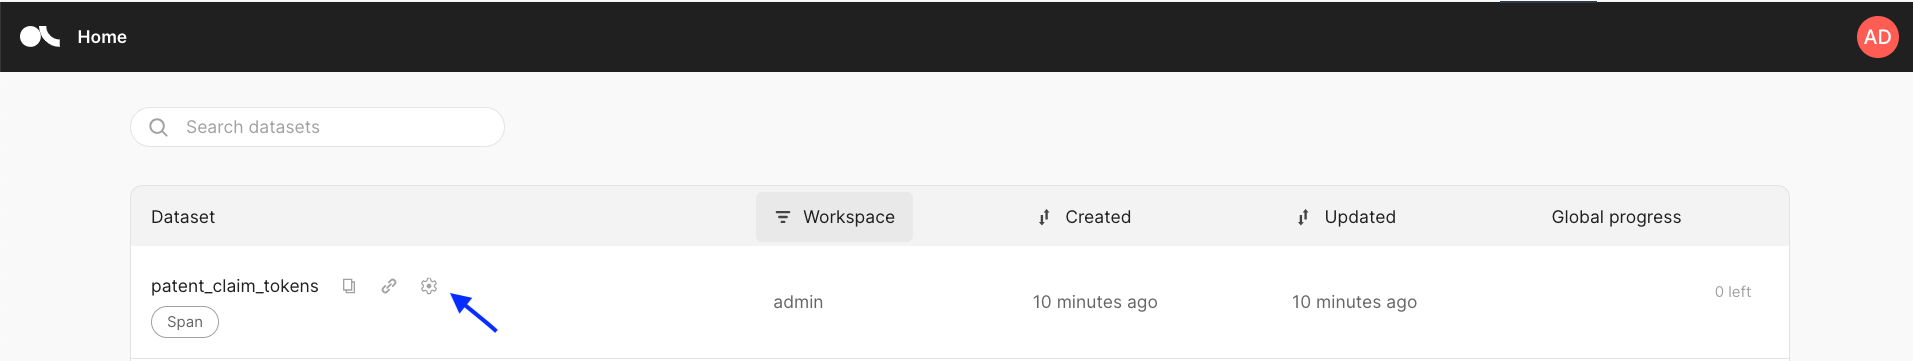

In [76]:
from IPython.display import Image, display
def display_image(filename):
  display(Image(filename=filename))
display_image('/content/argilla_ds_list_settings.png')

 The Fields tab of settings screen lists down fields we configured while creating the dataset using Python SDK.

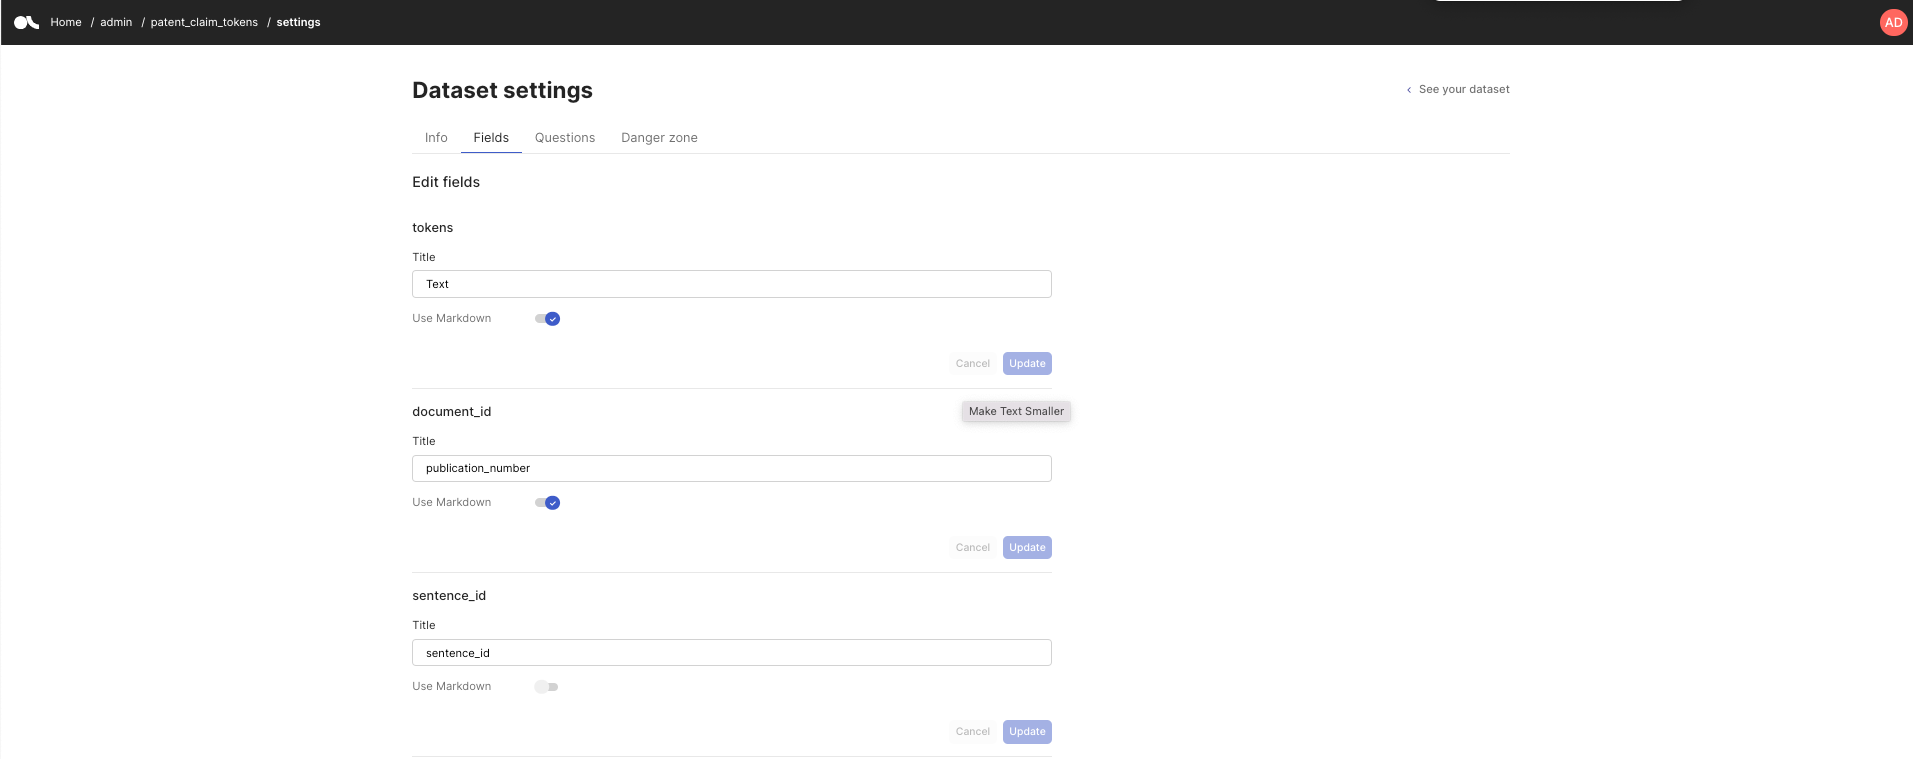

In [77]:
display_image('/content/argilla_ds_settings.png')

####Step 5: Insert records to the Argilla datasets

Data preparation notebook can be found [here](https://www.kaggle.com/code/boredmgr/claim-sampling)

In [ ]:
import pandas as pd
claims = pd.read_csv("/content/sample_publications.csv")
claims.head(2)

,publication_number,sequence_id,tokens
0,US-4444749-A,0,A shampoo comprising an aqueous solution of an...
1,US-4444749-A,1,A shampoo comprising an aqueous solution of an...


In [ ]:
## We upload a csv with three columns : tokens, publication_number, sequence_id

publication_df = pd.read_csv("/content/sample_publications.csv")
## Convert dataframe rows to Argilla Records
records = [
    rg.Record(
        fields=
            {"tokens": "".join(row["tokens"])
            ,'document_id':str(row['publication_number'])
            ,'sentence_id':str(row['sequence_id'])
            })
  for _,row in publication_df.iterrows()
  ]
  ## Store Argilla records to Argilla Dataset
rg_dataset.records.log(records)

DatasetRecords: The provided batch size 256 was normalized. Using value 149.

Sending records...: 100%|██████████| 1/1 [00:00<00:00,  1.71batch/s]


DatasetRecords(Dataset(id=UUID('a187cdad-175e-4d87-989f-a529b9999bde') inserted_at=datetime.datetime(2024, 7, 28, 7, 23, 59, 902685) updated_at=datetime.datetime(2024, 7, 28, 7, 24, 1, 901701) name='claim_tokens' status='ready' guidelines='Classify individual tokens according to the specified categories, ensuring that any overlapping or nested entities are accurately captured.' allow_extra_metadata=False workspace_id=UUID('fd4fc24c-fc1f-4ffe-af41-d569432d6b50') last_activity_at=datetime.datetime(2024, 7, 28, 7, 24, 1, 901701) url=None))

Once, we have records pushed to Argilla Dataset, the UI will render the records and the labels for the annotator to annotate the text. Screeshots below.

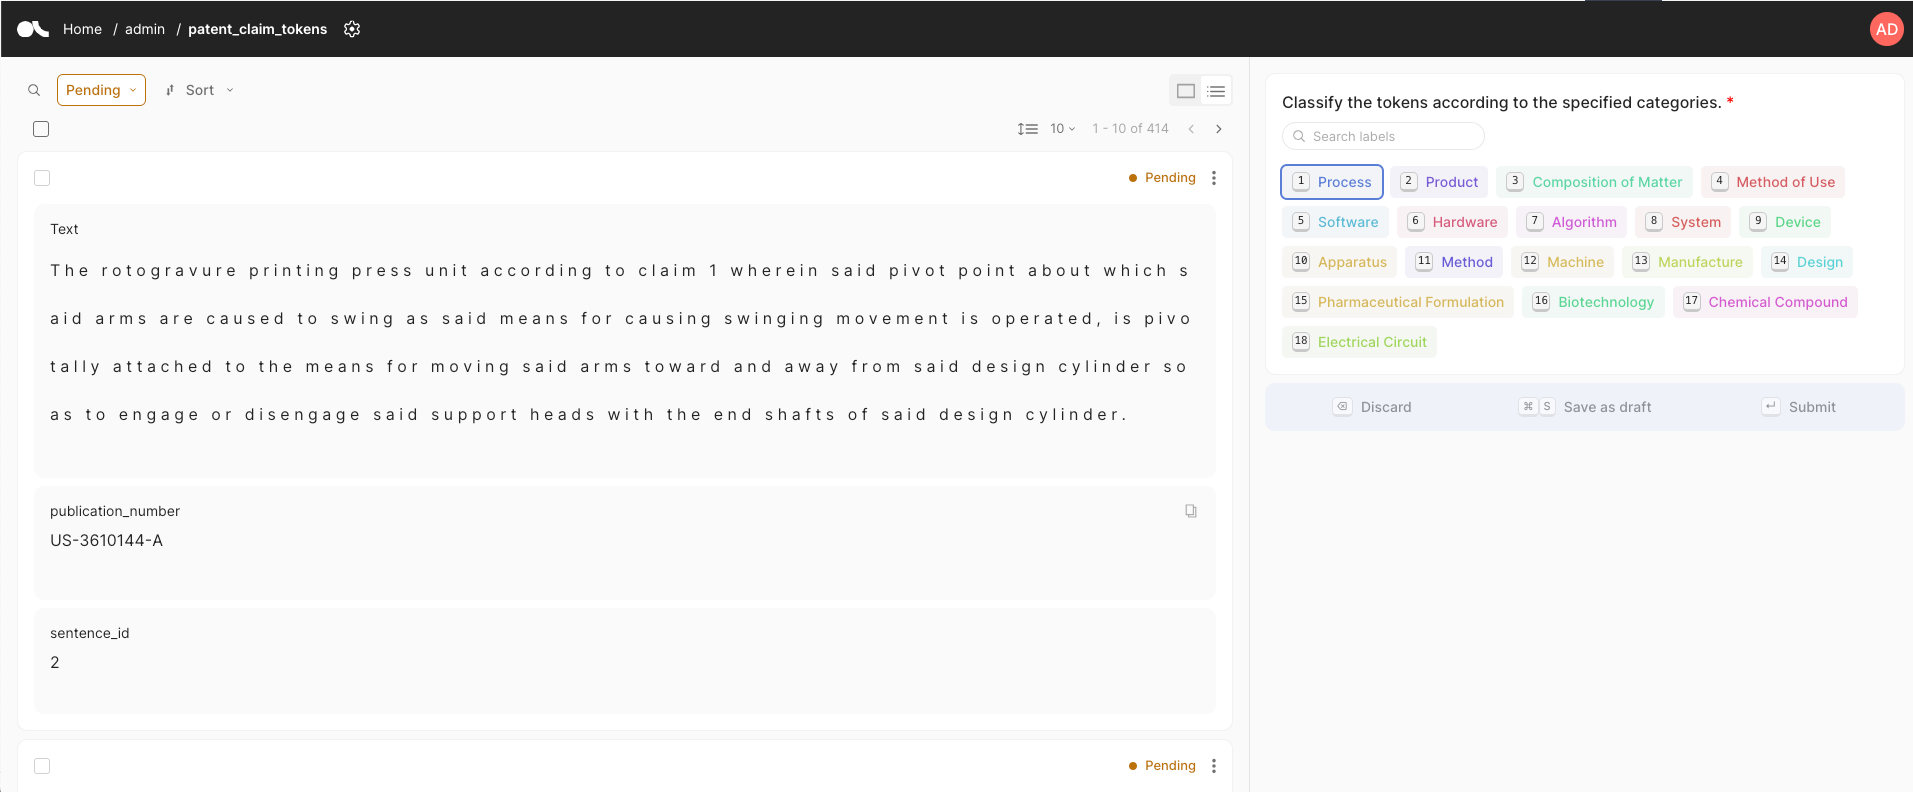

In [79]:
display_image("/content/annotation_screen.png")

####Step 6 : Annotate tokens in every records with appropriate labels.
Login to the Argilla UI and start annotating.

Argilla UI : `https://huggingface.co/spaces/<hf-username>/<hf-space-name>`

username : `admin`

password : `12345678`



> After annotating the data , we will have to convert Argilla Dataset to HuggingFace dataset in order to use HuggingFace AutoTrain for fine-tuning the model. HF AutoTrain allows training on CSV data too which can be uploaded from AutoTrain UI. But for this tutorial we will use Huggingface dataset.



## Argilla Dataset to HuggingFace Dataset

####Step 1: Import Statements

In [6]:
import re
import argilla as rg
from datasets import load_dataset, Dataset, DatasetDict

####Step 2: Load our annotated dataset

In [7]:
rg_dataset = client.datasets("claim_tokens")

####Step 3 : Filter the rows / records which are annotated.

In [8]:
status_filter = rg.Query(filter=rg.Filter(("response.status", "==", "submitted")))

submitted = rg_dataset.records(status_filter).to_list(flatten=True)
submitted[0]

{'id': '01e9b4bb-9c98-4cec-acea-dd686cddf5f0',
 '_server_id': '0b6f16f3-c3dc-4947-ac77-8b65002bf350',
 'tokens': 'The FINFET of  claim 11 , wherein the conformal gate dielectric comprises a high-κ gate dielectric selected from the group consisting of: hafnium oxide (HfO 2 ), lanthanum oxide (La 2 O 3 ), and combinations thereof.',
 'document_id': 'US-11631617-B2',
 'sentence_id': '14',
 'span_label.responses': [[{'label': 'Electrical Circuit',
    'start': 4,
    'end': 10},
   {'label': 'Chemical Compound', 'start': 138, 'end': 151},
   {'label': 'Chemical Compound', 'start': 162, 'end': 177}]],
 'span_label.responses.users': ['4e9588d6-e2d6-450d-82c6-b33324d94708']}

The annotated dataset cannot be fed as it is to the model for training. For token-classification task, we will have to make our data that adheres to the structure as described below.
- Dataset Structure: The dataset should typically have two main columns:
    - `tokens`: A list of words/tokens for each example.
    - `ner_tags`: A list of corresponding labels for each token. The labels must follow the [IOB labelling scheme](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)).
- Label Encoding: The labels should be integers, with each integer corresponding to a specific named entity tag.
Below functions will allow us to convert our Argilla dataset to the required dataset structure.


In [9]:
# ##
# ## Uncomment the below lines if you want to convert the Argilla records to pandas dataframe
# ##
# ##
# import pandas as pd
# from sklearn.model_selection import train_test_split
# # Creates the dataframe from Argilla Records
# labelled_df = pd.DataFrame(submitted)
# # Cast sentence_id to int
# labelled_df['sentence_id'] = labelled_df['sentence_id'].astype(int)
# # Cast document_id to int
# labelled_df['document_id'] = labelled_df['document_id'].astype(str)
# # Group by document_id
# grouped_df= labelled_df.groupby(by="document_id")
# # Take unique document_id
# publication_number = labelled_df['document_id'].unique()
# # Split the publication_numbers into train and test split
# train_ids, test_ids = train_test_split(publication_number, test_size=0.2, random_state=42)
# # Confirm test_ids and train_ids do not have any overlap
# elems = [elem for elem in train_ids if elem in test_ids]
# assert len(elems) == 0, f"Found overlapping elements: {elems}"
# # Train dataset by using the ids from train_ids
# train_df =  labelled_df[labelled_df['document_id'].isin(train_ids)]
# # Test dataset by using the ids from test_ids
# test_df =  labelled_df[labelled_df['document_id'].isin(test_ids)]
## Sort the train and test dataset by [document_id,sentence_id]
# sorted_train_df=train_df.sort_values(by=['document_id','sentence_id'],ascending=[True,True]).reset_index(drop=True)
# sorted_test_df=test_df.sort_values(by=['document_id','sentence_id'],ascending=[True,True]).reset_index(drop=True)
# len(sorted_train_df),len(sorted_test_df),len(train_ids),len(test_ids)

##### Vibe check

In [10]:
# row= sorted_train_df.iloc[0]
# print(row['tokens'])
# print(row['span_label.responses'][0])

In [11]:
def get_iob_tag_for_token(token_start, token_end, ner_spans):
    for span in ner_spans:
        if token_start >= span["start"] and token_end <= span["end"]:
            if token_start == span["start"]:
                return f"B-{span['label']}"
            else:
                return f"I-{span['label']}"
    return "O"


def extract_ner_tags(text, responses):
    tokens = re.split(r"(\s+)", text)
    ner_tags = []
    current_position = 0
    for token in tokens:
        if token.strip():
            token_start = current_position
            token_end = current_position + len(token)
            tag = get_iob_tag_for_token(token_start, token_end, responses)
            ner_tags.append(tag)
        current_position += len(token)
    return ner_tags

ner_tags = extract_ner_tags(submitted[0]['tokens'], submitted[0]['span_label.responses'][0])
print(ner_tags)

['O', 'B-Electrical Circuit', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Chemical Compound', 'I-Chemical Compound', 'O', 'O', 'O', 'B-Chemical Compound', 'I-Chemical Compound', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


####Step 4: Get tokens and theirs respective annotations

In [12]:
## Use this if you are using Dataframe instead of list.
#def get_tokens_ner_tags(df):
#   tokens = []
#   ner_tags = []
#   for idx,row in df.iterrows():
#       tags = extract_ner_tags(row["tokens"], row["span_label.responses"][0])
#       tks = [token for token in re.split(r"(\s{2,3})",row['tokens']) if token.strip() != ""]
#       tokens.append(tks)
#       ner_tags.append(tags)
#   return tokens, ner_tags
# train_tokens, train_ner_tags = get_tokens_ner_tags(sorted_train_df)
# validation_tokens, validation_ner_tags = get_tokens_ner_tags(sorted_test_df)

In [13]:
def get_tokens_ner_tags(annotated_rows):
  tokens = []
  ner_tags = []
  for idx,row in enumerate(annotated_rows):
      tags = extract_ner_tags(row["tokens"], row["span_label.responses"][0])
      tks = row["tokens"].split()
      tokens.append(tks)
      ner_tags.append(tags)
  return tokens, ner_tags
train_tokens, train_ner_tags = get_tokens_ner_tags(submitted[:1])
validation_tokens, validation_ner_tags = get_tokens_ner_tags(submitted[1:2])


##### Vibe Check

In [14]:
print(train_tokens[0][10:]),print(train_ner_tags[0][10:])

['dielectric', 'comprises', 'a', 'high-κ', 'gate', 'dielectric', 'selected', 'from', 'the', 'group', 'consisting', 'of:', 'hafnium', 'oxide', '(HfO', '2', '),', 'lanthanum', 'oxide', '(La', '2', 'O', '3', '),', 'and', 'combinations', 'thereof.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Chemical Compound', 'I-Chemical Compound', 'O', 'O', 'O', 'B-Chemical Compound', 'I-Chemical Compound', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


(None, None)

In [15]:
print(validation_tokens[0][10:]),print(validation_ner_tags[0][10:])

['or', 'more', 'possible', 'design', 'modification', 'solutions', 'based', 'at', 'least', 'in', 'part', 'on', 'the', 'set', 'of', 'attack', 'mitigation', 'rules', 'comprises', 'generating', 'the', 'one', 'or', 'more', 'possible', 'design', 'modification', 'solutions', 'by', 'inputting', 'the', 'set', 'of', 'attack', 'mitigation', 'rules', 'to', 'a', 'model', 'configured', 'to', 'perform', 'structural', 'and', 'functional', 'analysis', 'to', 'interpret', 'the', 'set', 'of', 'attack', 'mitigation', 'rules,', 'wherein', 'the', 'set', 'of', 'attack', 'mitigation', 'rules', 'comprises', 'one', 'or', 'more', 'rules', 'used', 'by', 'the', 'model', 'to', 'identify', 'the', 'key-gate', 'type', 'for', 'each', 'possible', 'design', 'modification', 'solution', 'of', 'the', 'one', 'or', 'more', 'possible', 'design', 'modification', 'solutions', 'and', 'one', 'or', 'more', 'rules', 'used', 'by', 'the', 'model', 'to', 'identify', 'the', 'location', 'where', 'to', 'insert', 'the', 'key-gate', 'type', 

(None, None)

As we are trying to have our data creation and model training pipeline working, for simplicity , I have dealing with one record each for training and validation.

####Step 5: Map labels (tags) to integers

In [16]:
def mapped_ner_tags(ner_tags):
  labels = list(set([item for sublist in ner_tags for item in sublist]))
  id2label = {i: label for i, label in enumerate(labels)}
  label2id = {label: id_ for id_, label in id2label.items()}
  mapped_ner_tags = [[label2id[label] for label in ner_tag] for ner_tag in ner_tags]
  return mapped_ner_tags

def get_labels(ner_tags):
  return list(set([item for sublist in ner_tags for item in sublist]))

####Step 6: Argilla Dataset to HuggingFace Dataset
We now have our data in a structure as required for token classification dataset. We will just have to create a Hugging Face Dataset.

In [18]:
from datasets import load_dataset, Dataset, DatasetDict,ClassLabel,Sequence,Value,Features
train_labels = get_labels(train_ner_tags)
validation_labels = get_labels(validation_ner_tags)
labels = list(set(train_labels + validation_labels))
print(f"{labels}",len(labels))
features = Features({
    "tokens": Sequence(Value("string")),
    "ner_tags": Sequence(ClassLabel(num_classes=len(labels), names=labels))
})
train_records = [
    {
        "tokens": token,
        "ner_tags": ner_tag,
    }
    for token, ner_tag in zip(train_tokens, mapped_ner_tags(train_ner_tags))
]
validation_records = [
    {
        "tokens": token,
        "ner_tags": ner_tag,
    }
    for token, ner_tag in zip(validation_tokens, mapped_ner_tags(validation_ner_tags))
]
span_dataset = DatasetDict(
    {
        "train": Dataset.from_list(train_records,features=features),
        "validation": Dataset.from_list(validation_records,features=features),
    }
)

['B-Biotechnology', 'I-Process', 'B-Chemical Compound', 'B-Electrical Circuit', 'B-Process', 'I-Biotechnology', 'B-Algorithm', 'O', 'I-Algorithm', 'I-Chemical Compound'] 10


In [19]:
print(span_dataset)

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 1
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 1
    })
})


In [20]:
print(span_dataset['train'].features['ner_tags'].feature.names)

['B-Biotechnology', 'I-Process', 'B-Chemical Compound', 'B-Electrical Circuit', 'B-Process', 'I-Biotechnology', 'B-Algorithm', 'O', 'I-Algorithm', 'I-Chemical Compound']


####Step 7: Push dataset to Hugginface Hub

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
span_dataset.push_to_hub("bikashpatra/sample_claims_annotated_hf")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/bikashpatra/sample_claims_annotated_hf/commit/e9faaa35dda423fcb2bccde9f19cbacd832af80a', commit_message='Upload dataset', commit_description='', oid='e9faaa35dda423fcb2bccde9f19cbacd832af80a', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
ds = load_dataset("bikashpatra/sample_claims_annotated_hf")
print(ds)

Generating train split:   0%|          | 0/1 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 1
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 1
    })
})


In [ ]:
print(ds['train'][0])

{'tokens': ['The', 'FINFET', 'of', 'claim', '11', ',', 'wherein', 'the', 'conformal', 'gate', 'dielectric', 'comprises', 'a', 'high-κ', 'gate', 'dielectric', 'selected', 'from', 'the', 'group', 'consisting', 'of:', 'hafnium', 'oxide', '(HfO', '2', '),', 'lanthanum', 'oxide', '(La', '2', 'O', '3', '),', 'and', 'combinations', 'thereof.'], 'ner_tags': [0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0]}


## Model Fine-tuning using AutoTrain
Huggingface [AutoTrain](https://huggingface.co/autotrain) is a simple tool to train model without writing a any code. We can use autotrain to fine-tune for a range of tasks like token-classification, text-generation, Image Classification and many more. In order to use AutoTrain, we will have to first create an instance of AutoTrain in HF space. Use the [create space](https://huggingface.co/new-space?template=autotrain-projects%2Fautotrain-advanced) link. For space SDK choose Docker and select AutoTrain as Docker template. We need to choose a hardware to train our model. Check the screenshots for a quick reference


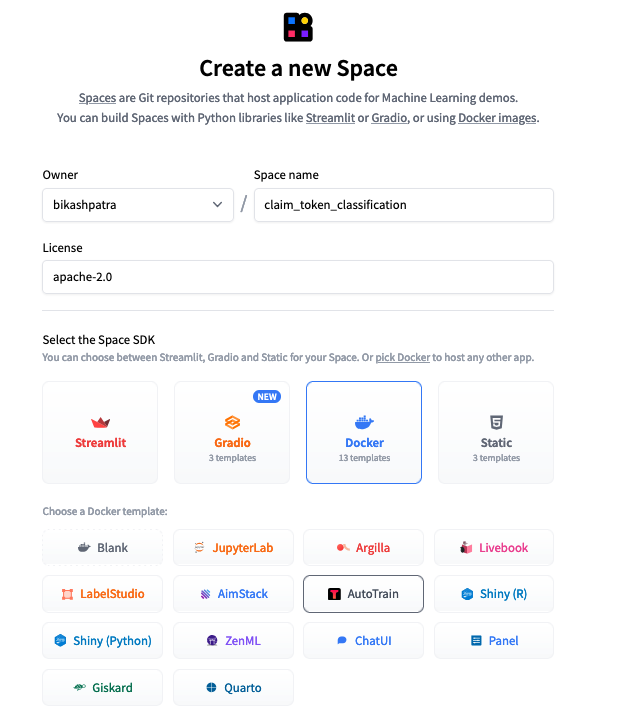

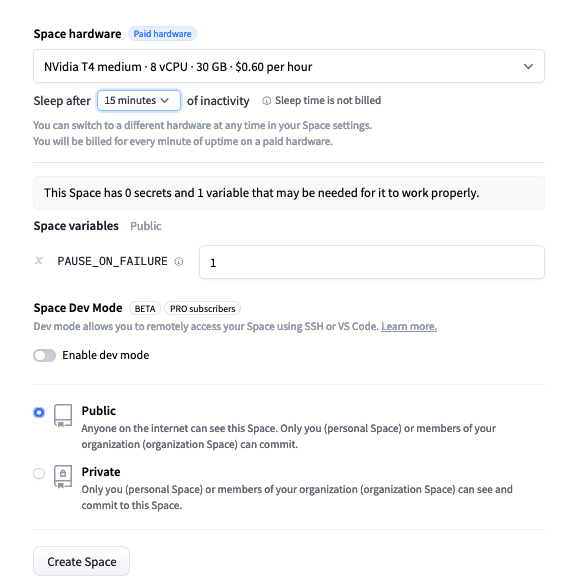

In [80]:
display_image("/content/autotrain_screen1.png")
display_image("/content/autotrain_screen2.png")

###Using AutoTrain UI



After space creation, AutoTrain UI will allow us to select from range of tasks. We will have to configure our trainer on the AutoTrain UI.
1. We will select Token classification as our task.
2. For our tutorial we will fine-tune `google-bert/bert-base-uncased`. We can choose any model from the list.
3. For DataSource select `Hugging Face Hub` which will give us a text box to fill in the dataset which we want to use for fine-tuning. We will use the dataset we pushed to Huggingface hub. I will be using the dataset that I pushed to huggingface hub `bikashpatra/claims_annotated_hf`
4. Enter the keys for `train` and `validation` split.
5. Under Column Mapping , enter the columns which store the tokens and tags. In my dataset , tokens are stored in `tokens` column and labels are stored in `ner_tags` column.
With the above 5 inputs, we can trigger `Start Training` and AutoTrain will take care of fine-tuning the base model on our dataset.

###Using AutoTrain cli

In [1]:
!pip install -qqqU autotrain-advanced

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 36.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 335.0/335.0 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.0/314.0 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.7/155.7 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.7/223.7 kB 14.2 MB/s et

In [2]:
from google.colab import userdata
import os
os.environ['TOKEN'] = userdata.get('HF_TOKEN')

In [3]:
!autotrain token-classification --train \
           --username "bikashpatra" \
           --token $TOKEN \
           --backend "spaces-a10g-small" \
           --project-name "claims-token-classification" \
           --data-path "bikashpatra/sample_claims_annotated_hf" \
           --train-split "train" \
           --valid-split "validation" \
           --tokens-column "tokens" \
           --tags-column "ner_tags" \
           --model "distilbert-base-uncased" \
           --lr "2e-5" \
           --log "tensorboard" \
           --epochs "10" \
           --weight-decay "0.01" \
           --warmup-ratio "0.1" \
           --max-seq-length "256" \
           --mixed-precision "fp16" \
           --push-to-hub

INFO     | 2024-07-29 03:09:39 | autotrain.cli.run_token_classification:run:179 - Running Token Classification
WARNING  | 2024-07-29 03:09:39 | autotrain.trainers.common:__init__:180 - Parameters supplied but not used: deploy, func, inference, version, config, backend, train
INFO     | 2024-07-29 03:09:41 | autotrain.cli.run_token_classification:run:185 - Job ID: bikashpatra/autotrain-claims-token-classification


AutoTrain automatically creates huggingface space for us and triggers the training job. Link to the space is `https://huggingface.co/spaces/$JOBID where JOBID is the value that we get from the logs of autotrain cli command.


If the model training executes without any errors, our model is available with the value we provided to `--project-name`. In the above example it was `claims-token-classification`

##Inference

In [22]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("bikashpatra/claims-token-classification")
model = AutoModelForTokenClassification.from_pretrained("bikashpatra/claims-token-classification")
claims_text = """
The FINFET of  claim 11 , wherein the conformal gate dielectric comprises a high-κ gate dielectric selected from
the group consisting of: hafnium oxide (HfO 2 ), lanthanum oxide (La 2 O 3 ), and combinations thereof.
"""
input_tokens = tokenizer(claims_text, return_tensors="pt")
output = model(**input_tokens)

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

In [63]:
# The labels used for training the model.
print(f"labels : \n {model.config.id2label}")

labels : 
 {0: 'B-Chemical Compound', 1: 'I-Biotechnology', 2: 'B-Electrical Circuit', 3: 'B-Process', 4: 'B-Biotechnology', 5: 'O', 6: 'I-Chemical Compound', 7: 'I-Process', 8: 'B-Algorithm', 9: 'I-Algorithm'}


In [69]:
def decode(token):
  return tokenizer.decode(token)

def get_label(model,token_logits):
  return model.config.id2label[token_logits.argmax().item()]


def get_prediction(text):
  input_tokens = tokenizer(text, return_tensors="pt")
  output = model(**input_tokens)
  token_label_dict = {decode(token):get_label(model,output.logits[0][i]) for i,token in enumerate(input_tokens.input_ids[0])}
  return token_label_dict

token_label = get_prediction(claims_text)

In [70]:
token_label

{'[CLS]': 'B-Process',
 'the': 'B-Biotechnology',
 'fin': 'O',
 '##fe': 'O',
 '##t': 'B-Process',
 'of': 'B-Biotechnology',
 'claim': 'B-Biotechnology',
 '11': 'B-Process',
 ',': 'I-Process',
 'wherein': 'B-Process',
 'conform': 'B-Biotechnology',
 '##al': 'I-Algorithm',
 'gate': 'B-Electrical Circuit',
 'die': 'B-Electrical Circuit',
 '##le': 'B-Algorithm',
 '##ctric': 'B-Electrical Circuit',
 'comprises': 'B-Electrical Circuit',
 'a': 'B-Biotechnology',
 'high': 'B-Algorithm',
 '-': 'B-Biotechnology',
 'κ': 'B-Biotechnology',
 'selected': 'B-Biotechnology',
 'from': 'B-Biotechnology',
 'group': 'B-Biotechnology',
 'consisting': 'I-Algorithm',
 ':': 'B-Biotechnology',
 'ha': 'I-Chemical Compound',
 '##f': 'B-Algorithm',
 '##nium': 'B-Algorithm',
 'oxide': 'B-Electrical Circuit',
 '(': 'B-Electrical Circuit',
 'h': 'B-Process',
 '##fo': 'B-Biotechnology',
 '2': 'O',
 ')': 'I-Process',
 'lan': 'B-Algorithm',
 '##than': 'B-Algorithm',
 '##um': 'B-Algorithm',
 'la': 'I-Process',
 'o': 'B-